In [2]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.4 MB/s eta 0:00:00


GIF saved as frozenlake.gif


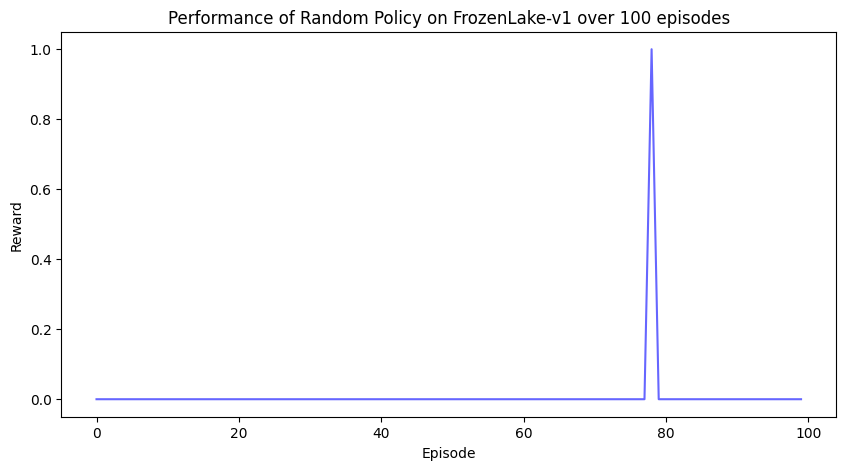

In [22]:
import gymnasium as gym
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import imageio
import matplotlib.pyplot as plt

# Initialize the FrozenLake environment
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='rgb_array')

def render_to_image(env):
    """Convert the text-based rendering to an image."""
    img = env.render()
    return img

def evaluate_and_save_gif(num_episodes=100, filename="frozenlake.gif"):
    """
    Evaluate a random policy, save the rendered outputs to a GIF, and return aggregated rewards.
    """
    frames = []
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        # Add initial state to frames
        frames.append(render_to_image(env))

        while not done:
            # Choose a random action
            action = env.action_space.sample()

            # Take a step in the environment
            next_state, reward, done, _, info = env.step(action)
            episode_reward += reward

            # Add the new state to frames
            frames.append(render_to_image(env))

        rewards.append(episode_reward)

    # Save frames as a gif
    imageio.mimsave(filename, [np.array(f) for f in frames], duration=0.5)
    print(f"GIF saved as {filename}")

    return rewards

# Evaluate the random policy, save the GIF, and retrieve rewards
num_episodes = 100
rewards = evaluate_and_save_gif(num_episodes=num_episodes, filename="frozenlake.gif")

# Plotting the aggregated rewards
plt.figure(figsize=(10, 5))
plt.plot(np.arange(num_episodes), rewards, alpha=0.6, color='blue')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Performance of Random Policy on FrozenLake-v1 over {} episodes'.format(num_episodes))
plt.show()
